In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import shap
import joblib
import hopsworks
import optuna
import warnings
warnings.filterwarnings('ignore')


### Connecting to Feature store and loading data

In [6]:
project = hopsworks.login(
    project="aqi_prediction72",
    api_key_file="hopsworks.key"
)

fs = project.get_feature_store()
feature_view = fs.get_feature_view("aqi_prediction_fv",version=1)

print("Creating training dataset")

td_version,td_job = feature_view.create_train_test_split(
    test_size=0.2,
    random_state=42,
    description="AQI Prediction Training dataset"
)
print(f"Training dataset created successfully! Version: {td_version}")
X_train,X_test,y_train,y_test = feature_view.get_train_test_split(
training_dataset_version=1,
test_size=0.2,
random_state=42
)


print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

feature_columns = [col for col in X_train.columns if col != 'timestamp']
X_train_features = X_train[feature_columns]
X_test_features = X_test[feature_columns]

print(f"Number of features for training: {len(feature_columns)}")


2025-10-12 00:53:26,254 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-10-12 00:53:26,262 INFO: Initializing external client
2025-10-12 00:53:26,264 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-10-12 00:53:29,722 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1257622
Creating training dataset
Training dataset job started successfully, you can follow the progress at 
http://c.app.hopsworks.ai/p/1257622/jobs/named/aqi_prediction_fv_1_create_fv_td_11102025195341/executions
2025-10-12 00:54:07,810 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-10-12 00:54:11,092 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-10-12 00:55:27,887 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-10-12 00:55:28,189 INFO: Waiting for log aggregation to finish.
2025-10-12

### Preprocesssing Data

In [7]:
X_train_clean = X_train_features.fillna(X_train_features.mean())
X_test_clean = X_test_features.fillna(X_test_features.mean())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)

print("Data Preprocessing Complete")

Data Preprocessing Complete


### Model Eval Function

In [8]:
def evaluate_model(y_true,y_pred,model_name):
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    mae = mean_absolute_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    
    print(f"{model_name} Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print("\n")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

model_results = {}
trained_models = {}

print("Evaluation function ready")
    

Evaluation function ready


### Random Forest

In [9]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth = 15,
    min_samples_split = 5,
    min_samples_leaf = 2,
    random_state = 42,
    n_jobs = -1
)


rf.fit(X_train_clean,y_train)
rf_predictions = rf.predict(X_test_clean)

rf_results = evaluate_model(y_test,rf_predictions,"Random Forest")
model_results['Random Forest'] = rf_results
trained_models['Random Forest'] = rf

print("Random Forest Training Complete")

Random Forest Performance:
RMSE: 0.5395
MAE: 0.1394
R2 Score: 1.0000


Random Forest Training Complete


### Ridge Regression

In [10]:
ridge = Ridge(
    alpha=1.0,
    random_state=42
)

ridge.fit(X_train_scaled,y_train)
ridge_predictions = ridge.predict(X_test_scaled)

ridge_results = evaluate_model(y_test,ridge_predictions,"Ridge Regression")
model_results['Ridge Regression'] = ridge_results
trained_models['Ridge Regression'] = ridge

print("Ridge Regression Training Complete")

Ridge Regression Performance:
RMSE: 0.1722
MAE: 0.0631
R2 Score: 1.0000


Ridge Regression Training Complete


### XGBoost

In [11]:
xgb = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_clean, y_train)
xgb_predictions = xgb.predict(X_test_clean)
xgb_results = evaluate_model(y_test,xgb_predictions,"XGBoost")
model_results['XGBoost'] = xgb_results
trained_models['XGBoost'] = xgb

print("XGBoost training completed")

XGBoost Performance:
RMSE: 1.0460
MAE: 0.6862
R2 Score: 0.9998


XGBoost training completed


### LightGBM

In [12]:
lgb = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb.fit(X_train_clean,y_train)
lgb_predictions = lgb.predict(X_test_clean)
lgb_results = evaluate_model(y_test,lgb_predictions,"LightGBM")
model_results['LightGBM'] = lgb_results
trained_models['LightGBM'] = lgb

print("LightGBM training completed")

LightGBM Performance:
RMSE: 1.0051
MAE: 0.5392
R2 Score: 0.9998


LightGBM training completed


### Pytorch NN

In [16]:
class AQIPredictor(nn.Module):
    def __init__(self,input_size):
        super(AQIPredictor,self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values.reshape(-1, 1))
X_test_tensor = torch.FloatTensor(X_test_scaled)
input_size = X_train_scaled.shape[1]
pytorch_model = AQIPredictor(input_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(pytorch_model.parameters(),lr=0.001)
epochs = 3000
pytorch_model.train()

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = pytorch_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        
pytorch_model.eval()
with torch.no_grad():
    pytorch_predictions = pytorch_model(X_test_tensor).numpy().flatten()
pytorch_results = evaluate_model(y_test,pytorch_predictions,"PyTorch Neural Network")
model_results['PyTorch Neural Network'] = pytorch_results
trained_models['PyTorch Neural Network'] = pytorch_model

print("PyTorch Neural Network training completed")

Epoch [50/3000], Loss: 18047.1875
Epoch [100/3000], Loss: 1347.5164
Epoch [150/3000], Loss: 594.0336
Epoch [200/3000], Loss: 460.1758
Epoch [250/3000], Loss: 396.9123
Epoch [300/3000], Loss: 363.8694
Epoch [350/3000], Loss: 311.2989
Epoch [400/3000], Loss: 295.2701
Epoch [450/3000], Loss: 282.5766
Epoch [500/3000], Loss: 275.1614
Epoch [550/3000], Loss: 279.5903
Epoch [600/3000], Loss: 261.7954
Epoch [650/3000], Loss: 257.1230
Epoch [700/3000], Loss: 245.2848
Epoch [750/3000], Loss: 247.9601
Epoch [800/3000], Loss: 242.3887
Epoch [850/3000], Loss: 227.6247
Epoch [900/3000], Loss: 231.5580
Epoch [950/3000], Loss: 226.3195
Epoch [1000/3000], Loss: 214.0875
Epoch [1050/3000], Loss: 220.9717
Epoch [1100/3000], Loss: 222.2612
Epoch [1150/3000], Loss: 202.8146
Epoch [1200/3000], Loss: 199.5316
Epoch [1250/3000], Loss: 205.9327
Epoch [1300/3000], Loss: 202.1492
Epoch [1350/3000], Loss: 200.9254
Epoch [1400/3000], Loss: 199.0991
Epoch [1450/3000], Loss: 183.9133
Epoch [1500/3000], Loss: 190.09

In [17]:
# Compare all model results
print("\n" + "="*60)
print("MODEL COMPARISON RESULTS")
print("="*60)

# Create comparison DataFrame
comparison_df = pd.DataFrame(model_results).T
comparison_df = comparison_df.round(4)

print(comparison_df)

# Find best model for each metric
best_rmse = comparison_df['RMSE'].min()
best_mae = comparison_df['MAE'].min()
best_r2 = comparison_df['R2'].max()

best_rmse_model = comparison_df[comparison_df['RMSE'] == best_rmse].index[0]
best_mae_model = comparison_df[comparison_df['MAE'] == best_mae].index[0]
best_r2_model = comparison_df[comparison_df['R2'] == best_r2].index[0]

print(f"\nBest Models:")
print(f"Lowest RMSE: {best_rmse_model} ({best_rmse:.4f})")
print(f"Lowest MAE:  {best_mae_model} ({best_mae:.4f})")
print(f"Highest R2:  {best_r2_model} ({best_r2:.4f})")

# Overall best model (based on R2 score)
overall_best_model = best_r2_model
print(f"\nOverall Best Model: {overall_best_model}")



MODEL COMPARISON RESULTS
                          RMSE     MAE      R2
Random Forest           0.5395  0.1394  1.0000
Ridge Regression        0.1722  0.0631  1.0000
XGBoost                 1.0460  0.6862  0.9998
LightGBM                1.0051  0.5392  0.9998
PyTorch Neural Network  2.5940  1.8813  0.9989

Best Models:
Lowest RMSE: Ridge Regression (0.1722)
Lowest MAE:  Ridge Regression (0.0631)
Highest R2:  Random Forest (1.0000)

Overall Best Model: Random Forest


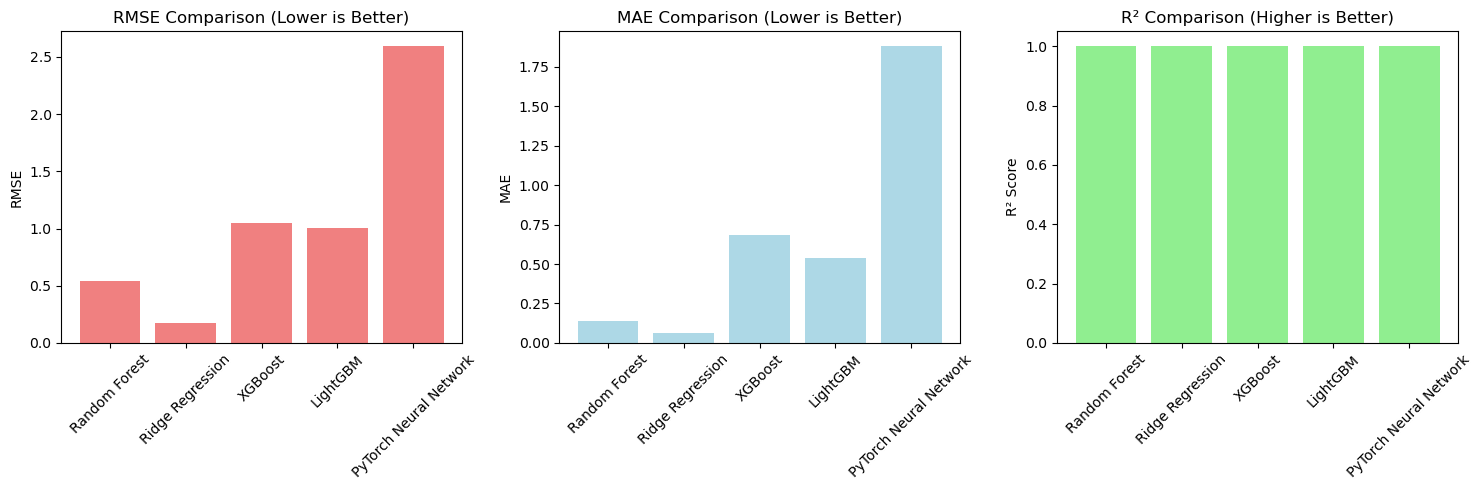

Model comparison visualization completed
Best performing model: Random Forest


In [18]:
# Visualize model performance
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE comparison
axes[0].bar(comparison_df.index, comparison_df['RMSE'], color='lightcoral')
axes[0].set_title('RMSE Comparison (Lower is Better)')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

# MAE comparison
axes[1].bar(comparison_df.index, comparison_df['MAE'], color='lightblue')
axes[1].set_title('MAE Comparison (Lower is Better)')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)

# R2 comparison
axes[2].bar(comparison_df.index, comparison_df['R2'], color='lightgreen')
axes[2].set_title('R² Comparison (Higher is Better)')
axes[2].set_ylabel('R² Score')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Model comparison visualization completed")
print(f"Best performing model: {overall_best_model}")